In [1]:
import pandas as pd
import numpy as np
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import disperse

In [2]:
cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [3]:
RA_int = (160, 240)
DEC_int = (0, 20)
Z_int = (0, 1.0)

In [4]:
galaxies = pd.read_csv('SDSS/SDSS_DR16.csv')
galaxies = galaxies[galaxies['class'] == 'GALAXY']
galaxies = galaxies[(RA_int[0] <= galaxies['ra']) & (galaxies['ra'] <= RA_int[1])]
galaxies = galaxies[(DEC_int[0] <= galaxies['dec']) & (galaxies['dec'] <= DEC_int[1])]
galaxies = galaxies[(Z_int[0] < galaxies['z']) & (galaxies['z'] <= Z_int[1])]
galaxies = galaxies[['ra', 'dec', 'z']]
galaxies.columns = ['RA', 'DEC', 'Z']
galaxies.drop_duplicates(subset=['RA', 'DEC', 'Z'])
galaxies.reset_index(drop=True, inplace=True)
galaxies

,RA,DEC,Z
0,160.79459,0.033496,0.083110
1,160.81317,0.023209,0.125813
2,160.84827,0.055476,0.127083
3,160.58358,0.039047,0.124137
4,160.63588,0.020746,0.113844
...,...,...,...
395215,181.07759,18.828807,0.868627
395216,181.04309,18.916253,0.943938
395217,180.45119,19.940874,0.107345
395218,182.61117,19.935709,0.887771


In [5]:
dat = Table.read('DR5_cluster-catalog_v1.1.fits', format='fits')
clusters = dat[['RADeg', 'decDeg', 'redshift', 'redshiftType']].to_pandas()
clusters = clusters[clusters['redshiftType'] == b'spec']
clusters = clusters[['RADeg', 'decDeg', 'redshift']]
clusters.columns = ['RA', 'DEC', 'Z']
clusters = clusters[(RA_int[0] <= clusters['RA']) & (clusters['RA'] <= RA_int[1])]
clusters = clusters[(DEC_int[0] <= clusters['DEC']) & (clusters['DEC'] <= DEC_int[1])]
clusters = clusters[(Z_int[0] < clusters['Z']) & (clusters['Z'] <= Z_int[1])]
clusters = clusters[['RA', 'DEC', 'Z']]
clusters.columns = ['RA', 'DEC', 'Z']
clusters.drop_duplicates(subset=['RA', 'DEC', 'Z'])
clusters.reset_index(drop=True, inplace=True)
clusters = clusters.assign(R=[0] * clusters.shape[0])
clusters

,RA,DEC,Z,R
0,160.265704,10.675110,0.789868,0
1,160.320666,19.972684,0.413140,0
2,160.659186,17.588787,0.442822,0
3,162.055869,9.598745,0.586733,0
4,162.537472,5.479127,0.417636,0
...,...,...,...,...
514,238.438790,3.855719,0.554680,0
515,238.755974,18.678286,0.358603,0
516,239.523481,13.723614,0.376000,0
517,239.545873,13.625000,0.237012,0


In [6]:
clusters['Z'].max()

0.975

In [7]:
DPS = disperse.Disperse3D(
    galaxies, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=clusters
)

In [8]:
DPS.count_cart_coords()

In [9]:
SIGMA = 5.0
SMOOTH = 1
BOARD = 'smooth'
ANGLE = 30

In [10]:
sigmas = [
         0.2, 0.4, 0.6, 0.8,
    1.0, 1.2, 1.4, 1.6, 1.8,
    2.0, 2.2, 2.4, 2.6, 2.8,
    3.0, 3.2, 3.4, 3.6, 3.8, 
    4.0, 4.2, 4.4, 4.6, 4.8, 
    5.0, 5.2, 5.4, 5.6, 5.8, 
    6.0, 6.2, 6.4, 6.6, 6.8,
    7.0, 7.2, 7.4, 7.6, 7.8,
    8.0, 8.2, 8.4, 8.6, 8.8,
    9.0, 9.2, 9.4, 9.6, 9.8,
    10.0, 10.2, 10.4, 10.6, 10.8,
    11.0, 11.2, 11.4, 11.6, 11.8,
    12.0, 12.2, 12.4, 12.6, 12.8,
    13.0, 13.2, 13.4, 13.6, 13.8,
    14.0
]

In [86]:
len(sigmas)

40

In [11]:
for sigma in sigmas:
    SIGMA = sigma
    print('### ', SIGMA)
    DPS.apply_disperse(SIGMA, SMOOTH, BOARD, ANGLE)
    DPS.save(f'ACT_01_dumps/{SIGMA}/')

In [12]:
true_cl_dists = []
false_cl_dists = []
for sigma in tqdm(sigmas):
    DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')
    DPS.gen_random_clusters()
    
    cl_conn, fil_conn, cl_dists \
        = DPS.count_conn([3] * DPS.clusters.shape[0])
    true_cl_dists.append(np.array(cl_dists)[None,:])
    
    cl_conn, fil_conn, cl_dists \
        = DPS.count_conn(
            [3] * DPS.clusters.shape[0], 
            DPS.random_clusters[0]
        )
    false_cl_dists.append(np.array(cl_dists)[None,:])

true_dists = np.concatenate(true_cl_dists, axis=0)
false_dists = np.concatenate(false_cl_dists, axis=0)

100%|██████████| 519/519 [00:00<00:00, 16480.13it/s]

>>> Generate random clusters




100%|██████████| 519/519 [00:00<00:00, 17662.45it/s]

100%|██████████| 519/519 [00:00<00:00, 15655.34it/s]

100%|██████████| 519/519 [00:00<00:00, 16155.52it/s]

100%|██████████| 40/40 [04:35<00:00,  6.89s/it]


In [13]:
true_dists = true_dists.T
false_dists = false_dists.T

In [14]:
true_dists.shape, false_dists.shape

((519, 40), (519, 40))

In [15]:
rads = list(range(1, 21))

In [16]:
true_sigmas = []
false_sigmas = []

for i, rad in enumerate(rads):
    t = np.zeros(clusters.shape[0])
    f = np.zeros(clusters.shape[0])
    for j, sigma in tqdm(enumerate(sigmas)):
        t[true_dists[:,j] <= rad] = sigma
        f[false_dists[:,j] <= rad] = sigma

    true_sigmas.append(t)
    false_sigmas.append(f)
    
true_sigmas = np.array(true_sigmas)
false_sigmas = np.array(false_sigmas)

40it [00:00, 68759.08it/s]
40it [00:00, 96978.13it/s]
40it [00:00, 70581.47it/s]
40it [00:00, 105054.58it/s]
40it [00:00, 80698.49it/s]
40it [00:00, 73103.34it/s]
40it [00:00, 51322.17it/s]
40it [00:00, 74071.59it/s]
40it [00:00, 60963.72it/s]
40it [00:00, 64206.72it/s]


In [17]:
true_sigmas = true_sigmas.T
false_sigmas = false_sigmas.T

In [18]:
true_sigmas.shape, false_sigmas.shape

((519, 10), (519, 10))

In [19]:
np.random.seed(0)
cl_num = 100
cl_idx = np.random.choice(list(range(true_dists.shape[0])), size=cl_num)

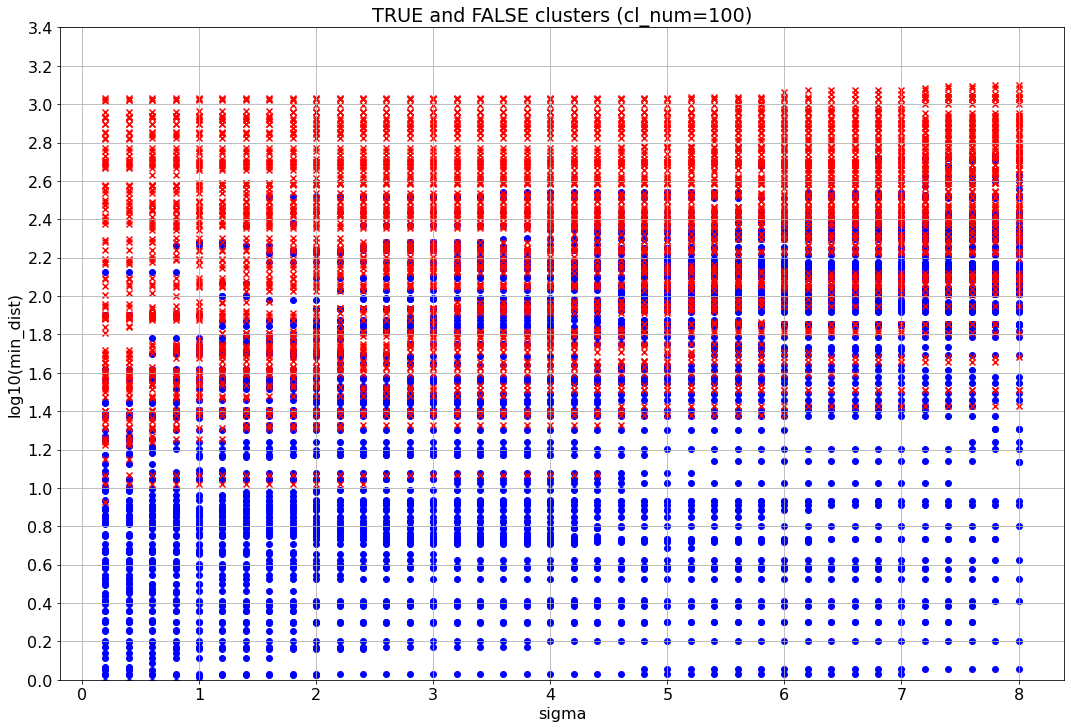

In [76]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 3.6, 0.2))
plt.ylim((0, 3.4))

for i in range(cl_num):
    plt.scatter(sigmas, np.log10(true_dists[cl_idx[i]]), c='b', marker='o')
    
for i in range(cl_num):
    plt.scatter(sigmas, np.log10(false_dists[cl_idx[i]]), c ='r', marker='x')
    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
# plt.legend()
plt.title(f'TRUE and FALSE clusters (cl_num={cl_num})')
plt.savefig(f'TRUE and FALSE clusters (cl_num={cl_num}).jpg')

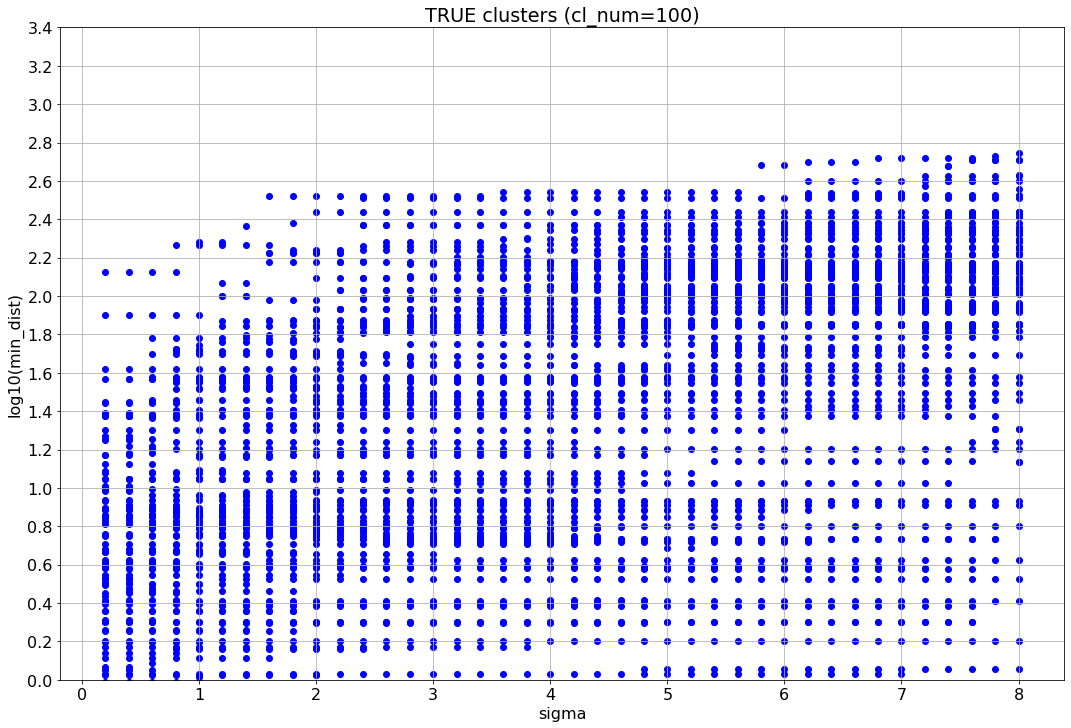

In [77]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 3.6, 0.2))
plt.ylim((0, 3.4))

for i in range(cl_num):
    plt.scatter(sigmas, np.log10(true_dists[cl_idx[i]]), c='b', marker='o')
    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
# plt.legend()
plt.title(f'TRUE clusters (cl_num={cl_num})')
plt.savefig(f'TRUE clusters (cl_num={cl_num}).jpg')

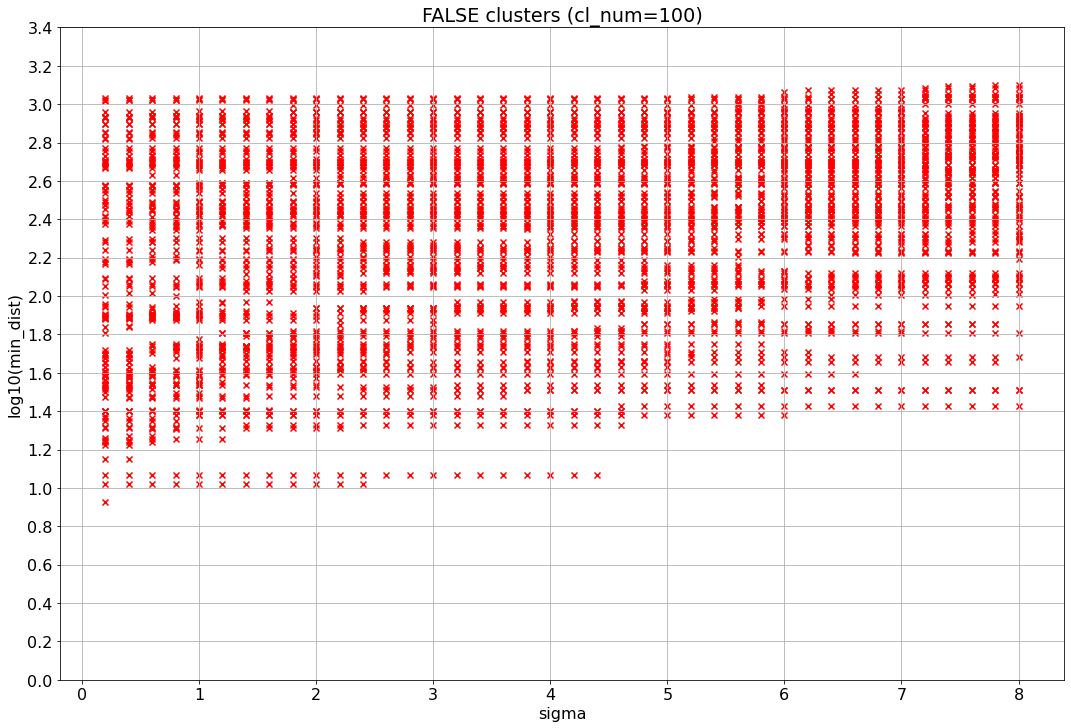

In [78]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 3.6, 0.2))
plt.ylim((0, 3.4))

for i in range(cl_num):
    plt.scatter(sigmas, np.log10(false_dists[cl_idx[i]]), c ='r', marker='x')
    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
# plt.legend()
plt.title(f'FALSE clusters (cl_num={cl_num})')
plt.savefig(f'FALSE clusters (cl_num={cl_num}).jpg')

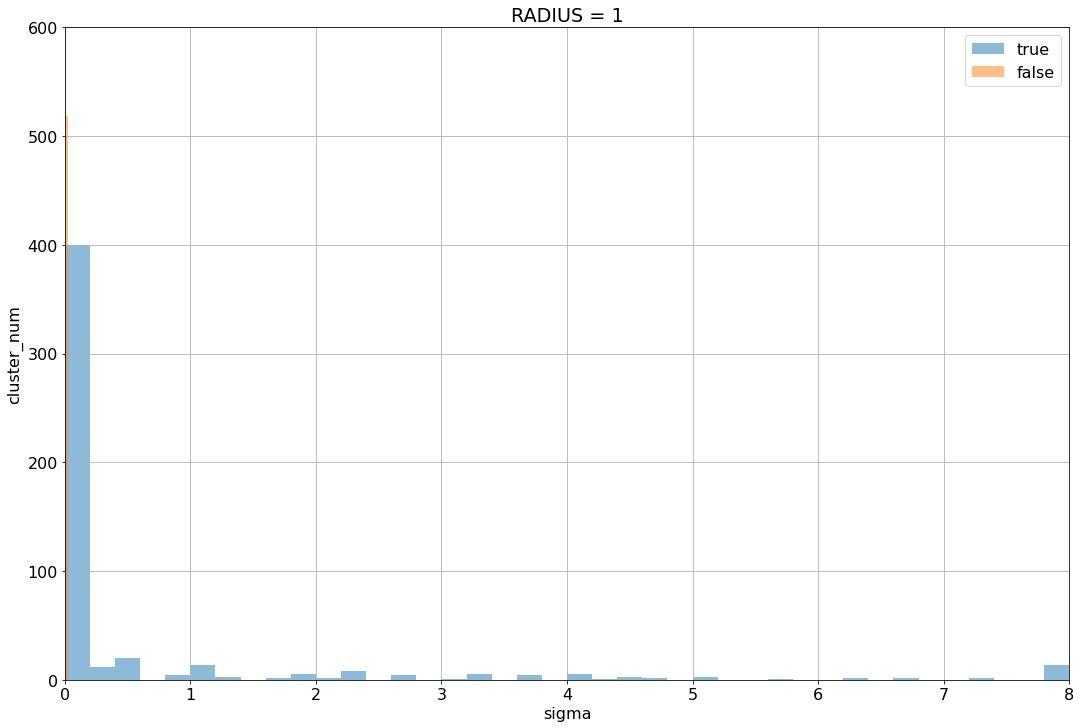

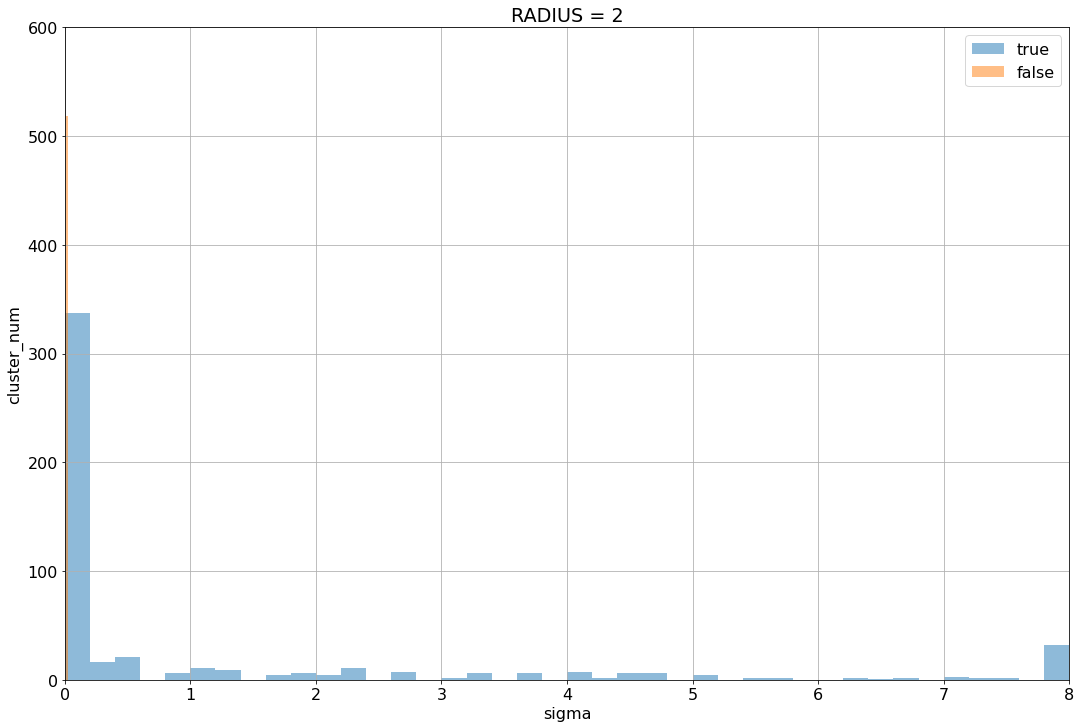

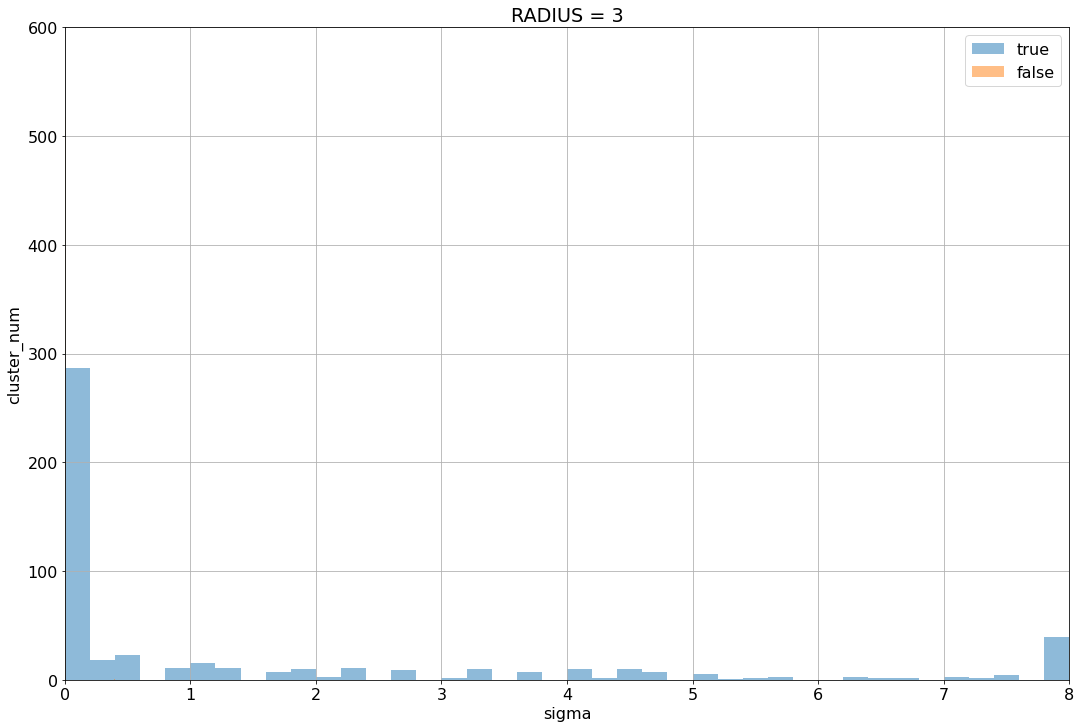

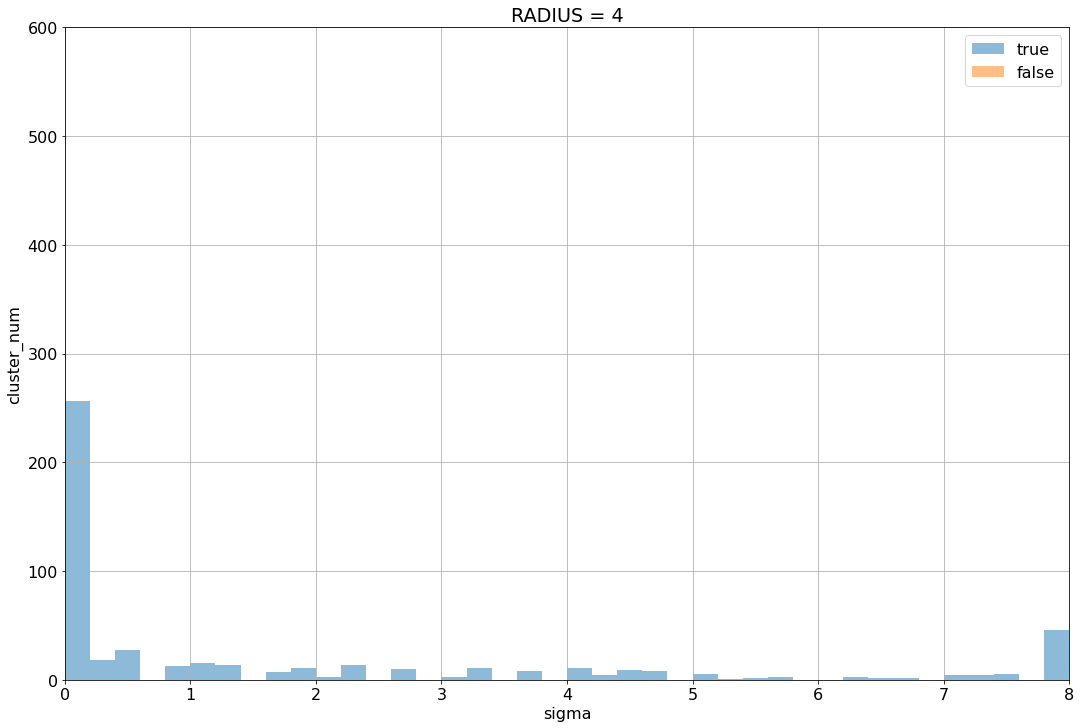

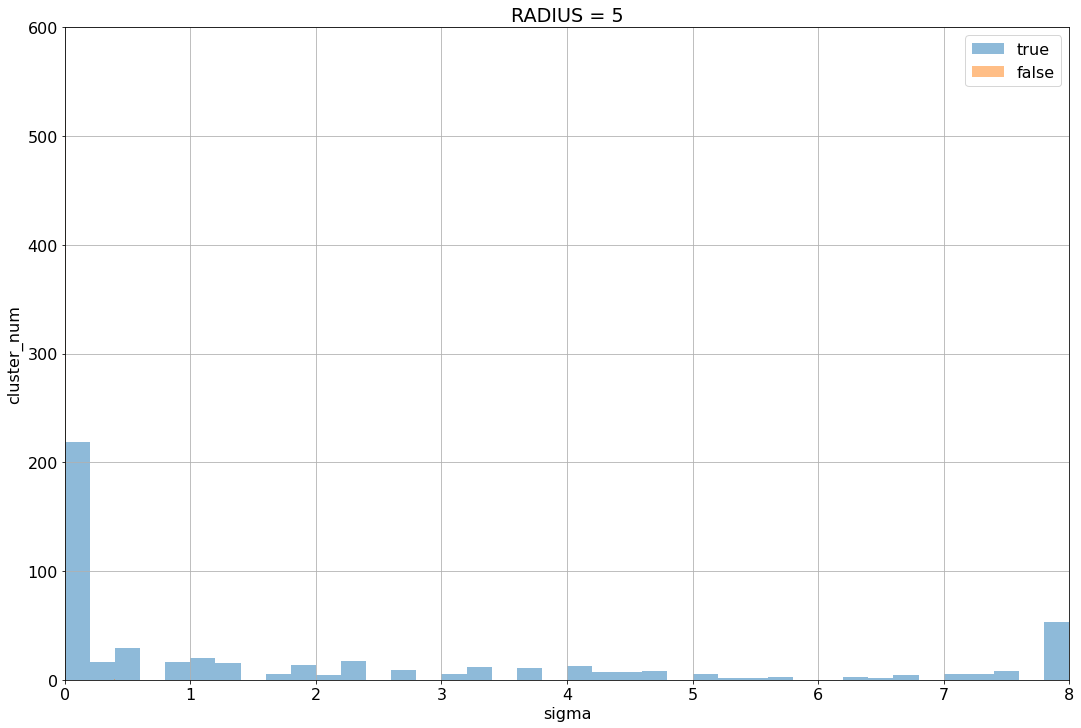

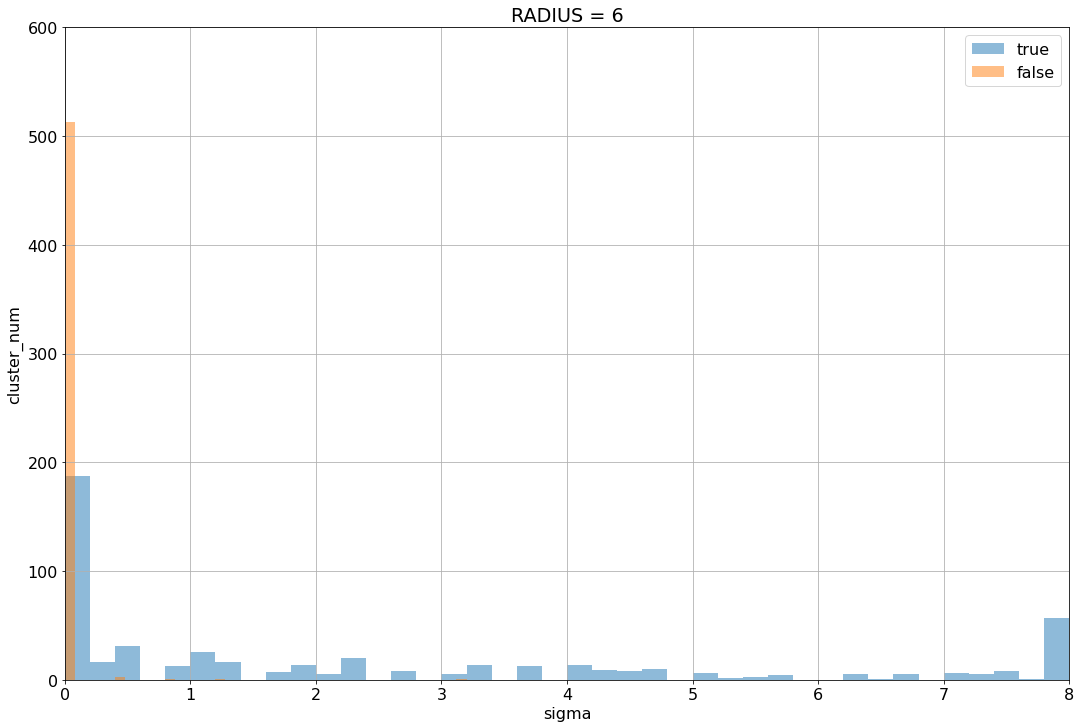

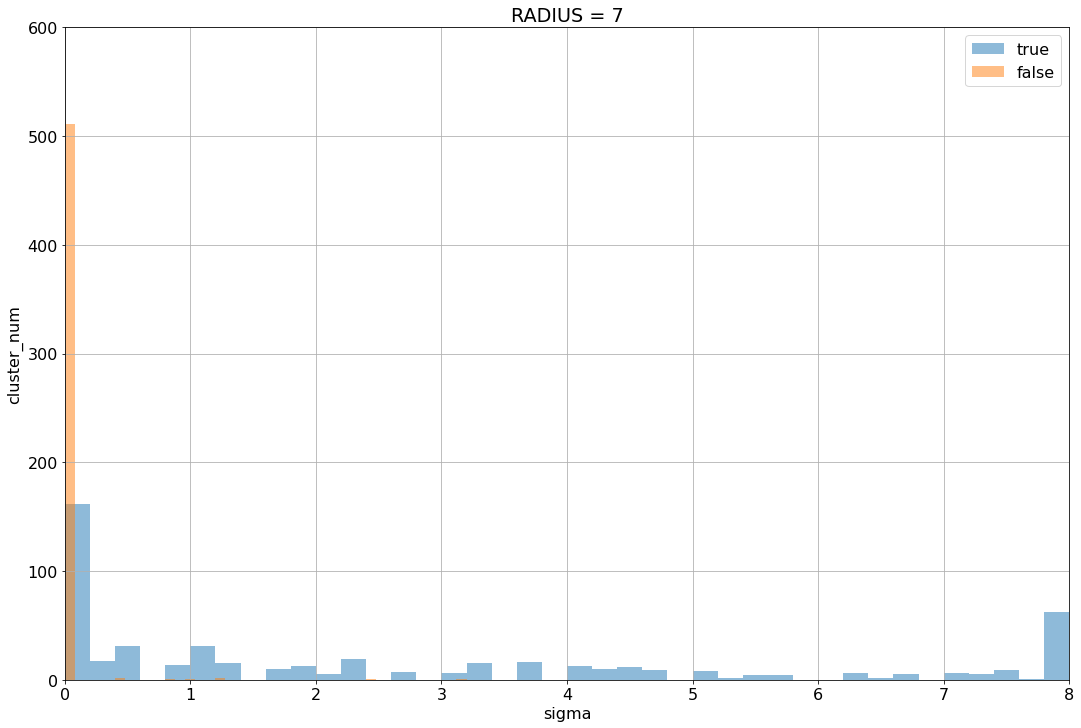

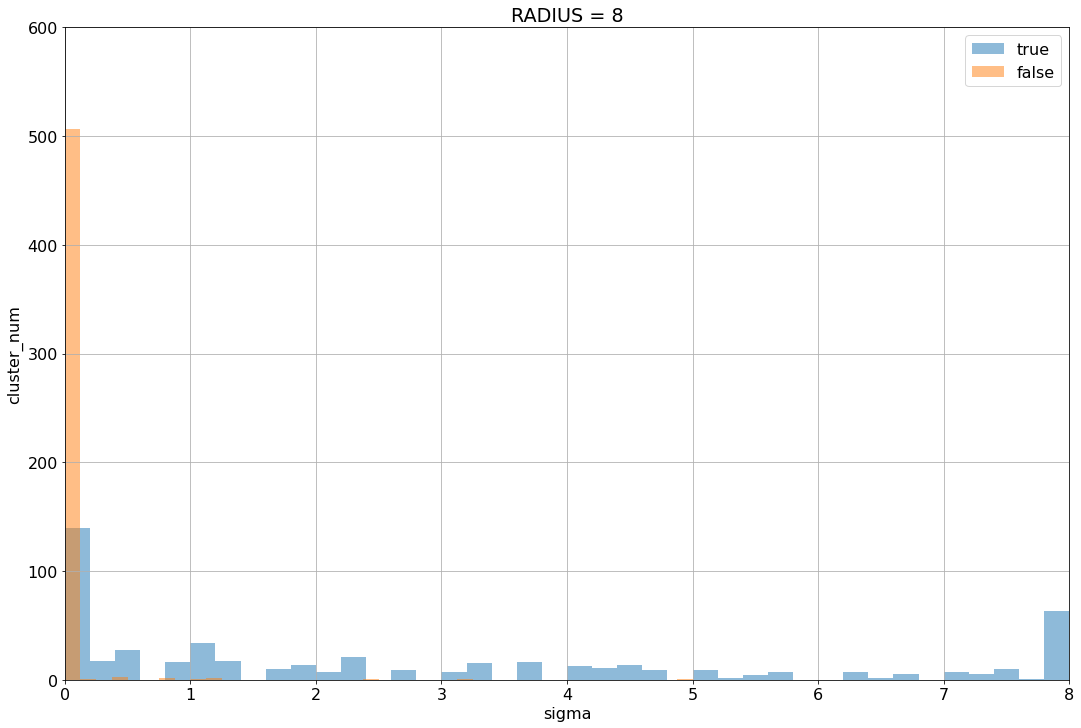

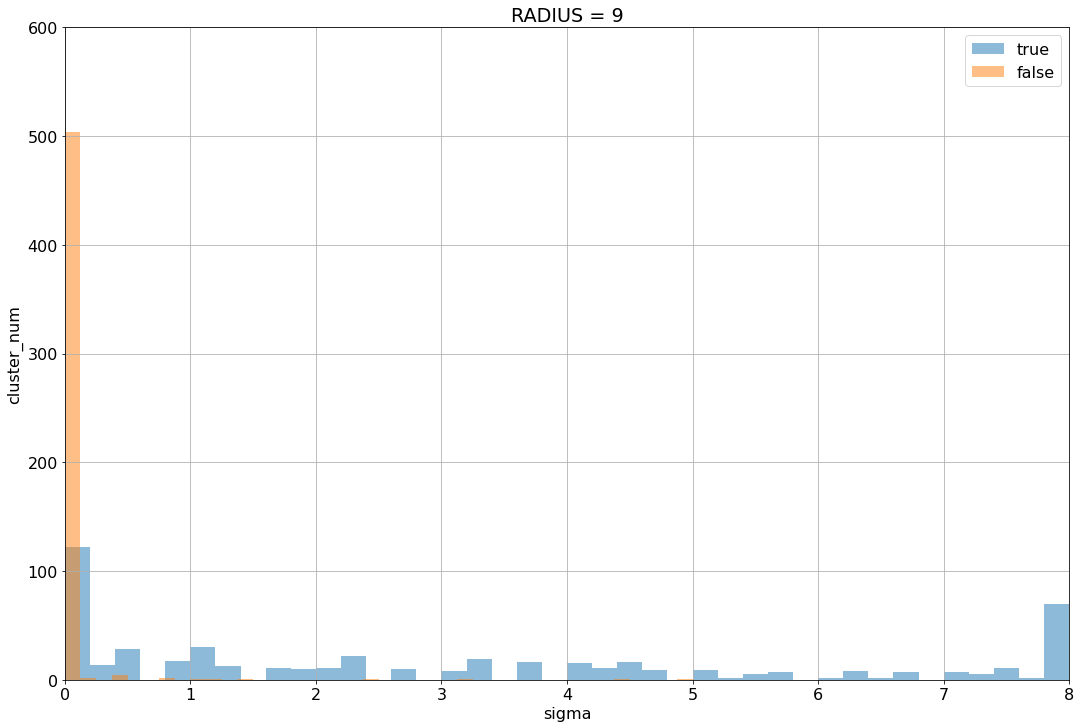

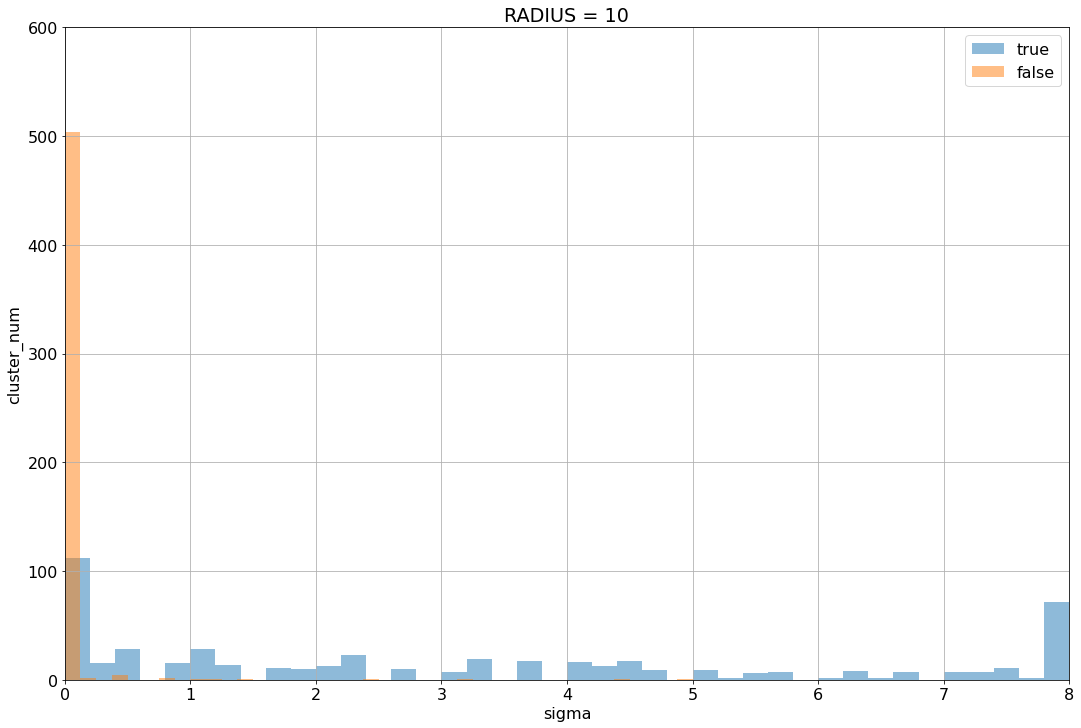

In [88]:
for i, rad in enumerate(rads):
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(18, 12))
    plt.grid()
    plt.xlim((0, 8))
    plt.ylim((0, 600))
    
    plt.hist(true_sigmas[:, i], density=False, bins=40, alpha=0.5, label='true')
    plt.hist(false_sigmas[:, i], density=False, bins=40, alpha=0.5, label='false')
    plt.xlabel('sigma')
    plt.ylabel('cluster_num')
    plt.legend()
    plt.title(f'RADIUS = {rad}')
    plt.savefig(f'RADIUS = {rad}.jpg')

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [23]:
X = np.concatenate((true_dists, false_dists), axis=0)
Y = np.array([1] * DPS.clusters.shape[0] + [0] * DPS.clusters.shape[0])

In [24]:
sigma_scores = np.concatenate((true_sigmas, false_sigmas), axis=0)

In [25]:
sigmas_roc_aucs = []
for i in range(len(rads)):
    sigmas_roc_aucs.append(roc_auc_score(Y, sigma_scores[:, i]))

In [26]:
sigmas_roc_aucs

[0.6146435452793835,
 0.6753371868978806,
 0.7228867579196692,
 0.7528001455296053,
 0.7885198673898597,
 0.8163691105987876,
 0.8390301491307205,
 0.8581884534138201,
 0.874317365914145,
 0.8842148640671812]

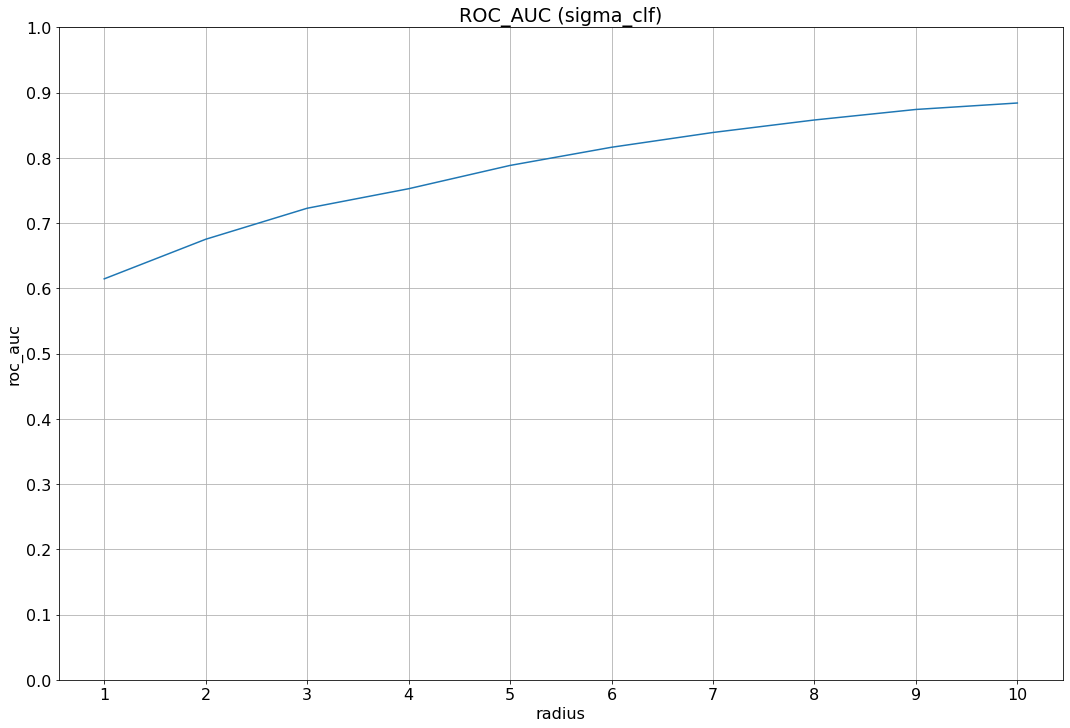

In [81]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.xticks(list(range(1, 11)))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim((0, 1))

plt.plot(rads, sigmas_roc_aucs)

    
plt.xlabel('radius')
plt.ylabel('roc_auc')
plt.title(f'ROC_AUC (sigma_clf)')
plt.savefig(f'ROC_AUC (sigma_clf).jpg')

In [28]:
sigmas = np.array(sigmas)
linreg_coef_scores = []
for i in range(X.shape[0]):
    reg = LinearRegression(fit_intercept=False).fit(sigmas.reshape(-1, 1), X[i].reshape(-1, 1))
    linreg_coef_scores.append(reg.coef_[0][0])
linreg_coef_scores = np.array(linreg_coef_scores)

In [29]:
roc_auc_score(Y, -linreg_coef_scores)

0.9000894710073098

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, stratify=Y, test_size=0.33
)

In [31]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, Y_train)
logreg_scores = clf.predict_proba(X_test)[:,1].reshape(-1)

/home/svasilyev/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
roc_auc_score(Y_test, logreg_scores)

0.9486264109887121

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(40, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        out = F.sigmoid(x)
        return out

In [35]:
torch.manual_seed(0)
model = Net()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
number_of_epochs = 2000
for epoch in range(number_of_epochs):
    Y_pred = model(torch.Tensor(X_train))
    loss = criterion(Y_pred, torch.Tensor(Y_train).view(-1, 1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%200 == 0:
        Y_pred = model(torch.Tensor(X_test))
        test_loss = criterion(Y_pred, torch.Tensor(Y_test).view(-1, 1))
        print(f'epoch: {epoch+1}, train_loss={loss.item()}, test_loss={test_loss}')

/home/svasilyev/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 200, train_loss=0.3935813903808594, test_loss=0.3883671462535858
epoch: 400, train_loss=0.3512875437736511, test_loss=0.3587345480918884
epoch: 600, train_loss=0.3352457582950592, test_loss=0.3491894602775574
epoch: 800, train_loss=0.32278406620025635, test_loss=0.3425009846687317
epoch: 1000, train_loss=0.31465551257133484, test_loss=0.34043335914611816
epoch: 1200, train_loss=0.30791524052619934, test_loss=0.33918818831443787
epoch: 1400, train_loss=0.30207881331443787, test_loss=0.337552011013031
epoch: 1600, train_loss=0.29767468571662903, test_loss=0.3375750780105591
epoch: 1800, train_loss=0.29336363077163696, test_loss=0.33784008026123047
epoch: 2000, train_loss=0.28821322321891785, test_loss=0.3373039960861206


In [36]:
net_scores = model(torch.Tensor(X_test)).view(-1).detach().numpy()

In [37]:
roc_auc_score(Y_test, net_scores)

0.9489664082687338

In [38]:
clf = RandomForestClassifier(
    max_depth=4, 
    random_state=0,
    n_estimators=500,
    max_features='auto'
).fit(X_train, Y_train)
rf_scores = clf.predict_proba(X_test)[:,1].reshape(-1)

In [39]:
roc_auc_score(Y_test, rf_scores)

0.9799401604787161

In [40]:
import pickle
with open('ACT_rf.pkl', 'wb') as f:
    pickle.dump(clf, f)